In [14]:
!pip install yfinance pandas numpy matplotlib seaborn scipy statsmodels

import requests
from bs4 import BeautifulSoup
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ttest_ind


In [21]:
#Policy dates (adjust based on actual dates for a given year)
policy_dates = [
    "2023-01-25", "2023-03-22", "2023-05-03", "2023-06-14", "2023-07-26", "2023-09-20"
]


# Indices and sectors to track
indices = {
    "S&P 500": "^GSPC",
    "Nasdaq": "^IXIC",
    "Dow Jones": "^DJI",
}

sectors = {
    "Technology": "^SP500-45",
    "Financials": "^SP500-40",
    "Healthcare": "^SP500-35",
}

# Event window (days before and after the policy event)
event_window = 10


In [22]:
# Function to fetch and clean data
def fetch_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    if "Adj Close" in data.columns:  # Use 'Adj Close' if available
        return data["Adj Close"]
    elif "Close" in data.columns:  # Fallback to 'Close'
        return data["Close"]
    else:
        raise ValueError(f"No valid price column found for {ticker}")

# Downloading data for indices and sectors
index_data = {name: fetch_data(ticker, start_date, end_date) for name, ticker in indices.items()}
sector_data = {name: fetch_data(ticker, start_date, end_date) for name, ticker in sectors.items()}


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [23]:
# Function to calculate daily returns
def calculate_returns(data):
    return data.pct_change().dropna()  # Compute percentage changes and drop NaNs

# Processing data for indices and sectors
index_returns = {name: calculate_returns(data) for name, data in index_data.items()}
sector_returns = {name: calculate_returns(data) for name, data in sector_data.items()}


In [24]:
# Function to extract event windows around policy dates
def extract_event_window(data, event_dates, window):
    event_data = []
    for date in event_dates:
        if date in data.index:
            loc = data.index.get_loc(date)
            start = max(0, loc - window)
            end = min(len(data), loc + window + 1)
            event_data.append(data.iloc[start:end].reset_index(drop=True))
    return pd.concat(event_data, axis=1)

# Aligning indices and sectors to event windows
aligned_indices = {name: extract_event_window(data, policy_dates, event_window) for name, data in index_returns.items()}
aligned_sectors = {name: extract_event_window(data, policy_dates, event_window) for name, data in sector_returns.items()}


In [9]:
# Function to calculate cumulative average returns
def cumulative_average(data):
    return data.mean(axis=1).cumsum()

# Calculating cumulative average returns for indices and sectors
cumulative_indices = {name: cumulative_average(data) for name, data in aligned_indices.items()}
cumulative_sectors = {name: cumulative_average(data) for name, data in aligned_sectors.items()}


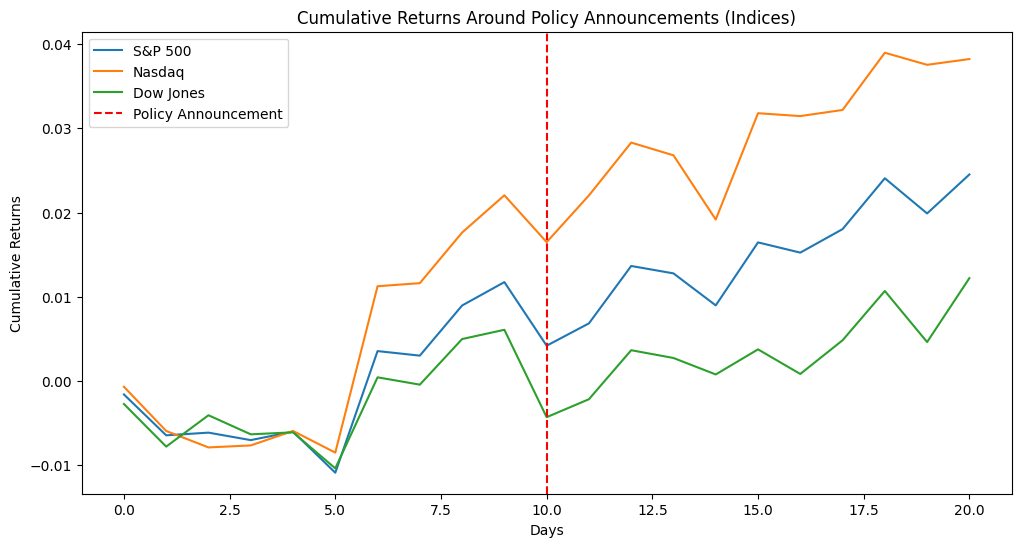

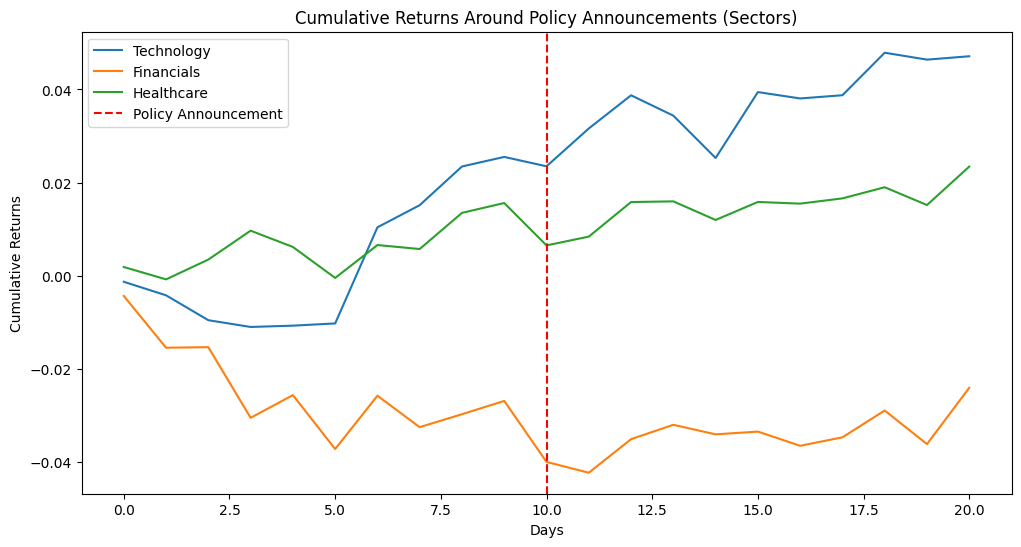

In [25]:
# Cumulative returns for indices
plt.figure(figsize=(12, 6))
for name, cum_returns in cumulative_indices.items():
    plt.plot(cum_returns, label=name)
plt.axvline(event_window, color='red', linestyle='--', label='Policy Announcement')
plt.title("Cumulative Returns Around Policy Announcements (Indices)")
plt.xlabel("Days")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

# Cumulative returns for sectors
plt.figure(figsize=(12, 6))
for name, cum_returns in cumulative_sectors.items():
    plt.plot(cum_returns, label=name)
plt.axvline(event_window, color='red', linestyle='--', label='Policy Announcement')
plt.title("Cumulative Returns Around Policy Announcements (Sectors)")
plt.xlabel("Days")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()


In [26]:
# T-test to compare returns before and after policy announcements
def t_test(data, window):
    before = data.iloc[:window].values.flatten()
    after = data.iloc[window:].values.flatten()
    return ttest_ind(after, before)

# T-test for indices
print("\nT-Test Results for Indices:")
for name, data in aligned_indices.items():
    stat, pval, _ = t_test(data, event_window)
    print(f"{name}: t-statistic = {stat:.2f}, p-value = {pval:.5f}")

#  T-test for sectors
print("\nT-Test Results for Sectors:")
for name, data in aligned_sectors.items():
    stat, pval, _ = t_test(data, event_window)
    print(f"{name}: t-statistic = {stat:.2f}, p-value = {pval:.5f}")



T-Test Results for Indices:
S&P 500: t-statistic = -0.91, p-value = 0.36702
Nasdaq: t-statistic = -0.80, p-value = 0.42531
Dow Jones: t-statistic = -1.00, p-value = 0.32026

T-Test Results for Sectors:
Technology: t-statistic = -0.78, p-value = 0.43536
Financials: t-statistic = -0.21, p-value = 0.83419
Healthcare: t-statistic = -1.42, p-value = 0.15922
